# Advanced Lane Detection

This implementation tries to find the current driving lane of a car. It is based on the technicts taught in the online course ["Self Driving Car Engineer" from Udacity](https://udacity.com/course/self-driving-car-engineer-nanodegree--nd013) and on the paper ["Real time Detection of Lane Markers in Urban Streets" by Mohamed Aly](http://www.mohamedaly.info/research/lane-detection)


## Image Distortion and Top View

This helps to remove perspective effects in an images. Lines that are actually parallel, converge at the horizon in an images captured by a camera. The calculation of a top view gets rid of this effect, so that lanes appear parallel. 

In [103]:

import glob
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# See jupyter notebook Camera_Calibration.jpynb
dist_pickle = pickle.load( open( "camera_cal_data/camera_calibration_data.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

plt_img_width = 10
plt_img_height = 8

def top_view(img, mtx, dist):
    # undistort image
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # top left, top right, bottom right, bottom left
    corners = [[603,440], [673,440], [1017, 660], [229,660]]
    
    img_height, img_width, img_depth = img.shape
    
    margin_horz = 250
    margin_vert = 0
   
    src_rect = np.float32(
        [corners[0], 
        corners[1],
        corners[2],
        corners[3]])

    dest_rect= np.float32([
        [margin_horz,             margin_vert],
        [img_width - margin_horz, margin_vert],
        [img_width - margin_horz, img_height - margin_vert],
        [margin_horz,             img_height - margin_vert]])

    M = cv2.getPerspectiveTransform(src_rect, dest_rect)
    Minv = cv2.getPerspectiveTransform(dest_rect, src_rect)
    warped = cv2.warpPerspective(img_undistorted, M, (img_width, img_height))
    return warped, M, Minv
                                 


This is an orignal image from camera

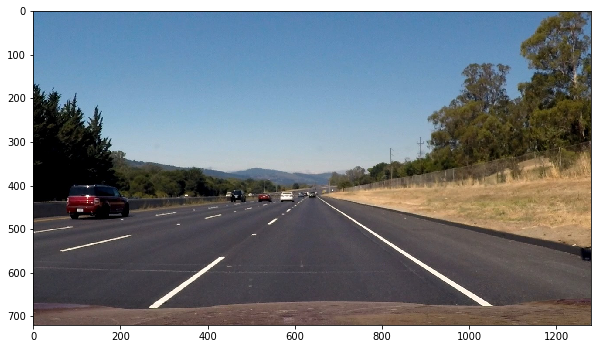

In [104]:
# read a distorted image
distorted_image = mpimg.imread('test_images/straight_lines2.jpg')

# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(distorted_image)


And this is the undistorted top view

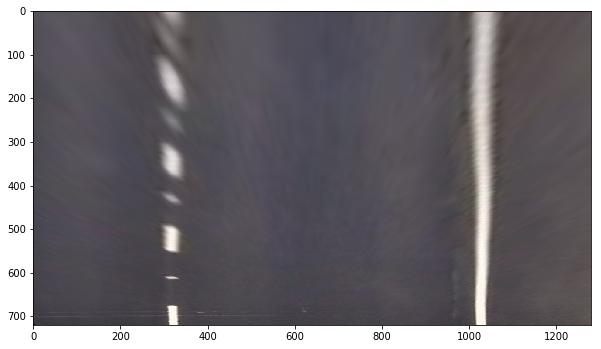

In [105]:
# read a distorted image
topview_image, M, Minv = top_view(distorted_image, mtx, dist) 

# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(topview_image)

# image dimensions
topview_image_height, topview_image_width, topview_image_depth = topview_image.shape 

This show the undistorted top view of all test images

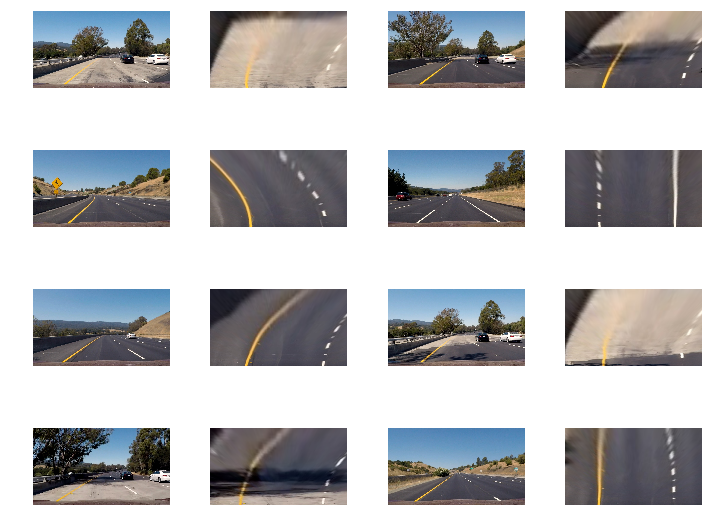

In [107]:
test_images_file_filter = 'test_images/*.jpg'
test_images_file_file_names = glob.glob(test_images_file_filter)
undistorted_top_views = []
distorted_images = []

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(plt_img_width, plt_img_height))
axs = axs.ravel()

for index, distorted_image_file_name in zip(range(len(test_images_file_file_names)), test_images_file_file_names):
    distorted_image = mpimg.imread(distorted_image_file_name)
    distorted_images.append(distorted_image)
    
    topview_image, M, Minv = top_view(distorted_image, mtx, dist)
    undistorted_top_views.append(topview_image)
    
    axs[index*2].imshow(distorted_image)
    axs[index*2].set_axis_off()
    axs[index*2+1].imshow(topview_image)
    axs[index*2+1].set_axis_off()
    
plt.tight_layout()


## Evaluation of color channel

Lane dividers have two major color properties, saturation and lightness, to contrast with the road. We may take advantages of this by transforming the image to the HLS color space.

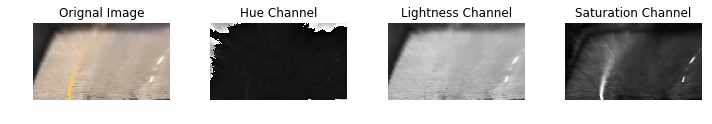

In [108]:
def show_hls_color_channels(channel_eval_image):
    hls_image = cv2.cvtColor(channel_eval_image, cv2.COLOR_RGB2HLS)
    h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(plt_img_width, plt_img_height))
    axs[0].set_title("Orignal Image")
    axs[0].imshow(channel_eval_image)
    axs[0].set_axis_off()
    axs[1].set_title("Hue Channel")
    axs[1].imshow(h_channel / 100.0, cmap='gray')
    axs[1].set_axis_off()
    axs[2].set_title("Lightness Channel")
    axs[2].imshow(l_channel, cmap='gray')
    axs[2].set_axis_off()
    axs[3].set_title("Saturation Channel")
    axs[3].imshow(s_channel, cmap='gray')
    axs[3].set_axis_off()
    plt.tight_layout()
    
show_hls_color_channels(undistorted_top_views[0])



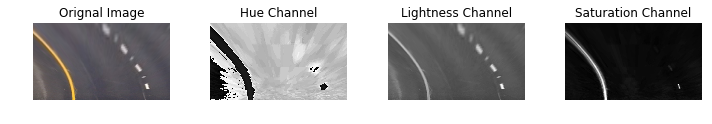

In [109]:
show_hls_color_channels(undistorted_top_views[2])

We can see that the saturation channel is suitable to extract yellow lines, whereas the lightness channel seems to extract white markes. 

## Marker extraction

Different to the approach from Udacity, I use gaussian spatial filters to detect vertical lines, as described in Mohamed Aly's paper on the lighness channel and on the saturation channel. The respons
e of this filter is then thresholded and merged.

In [110]:
# calucate the derivative of a gaussian
def get_derivative_gaussian(w, sigma):
    d = np.zeros(w*2+1)    
    
    for x in range(-w,w+1):
        i = x + w
        d[i] = (1.0/sigma**2) * np.exp((-(x**2)) / (2 * sigma**2)) * (1 - (x**2 / sigma**2))        
    
    return d

# calculate a gaussian
def get_gaussian(w, sigma):
    g = np.zeros(w*2+1)
    
    for x in range(-w,w+1):
        i = x + w
        g[i] = np.exp(-((x**2)/(2*sigma**2)))
    
    return g

# combine the derivative of a gaussian and a gaussian to a kernel
def get_convolution_kernel(kernel_width, kernel_height, sigma_width, sigma_height):
    derivative_gaussian = np.mat(get_derivative_gaussian(kernel_width,sigma_width))
    gaussian = np.mat(get_gaussian(kernel_height, sigma_height))
    kernel = gaussian.T * derivative_gaussian
    return kernel


### Gaussian Curves


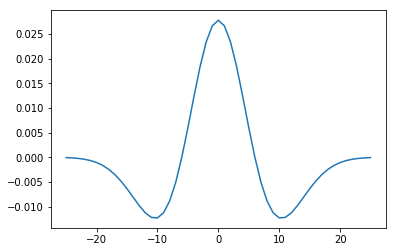

In [111]:
kernel_width = 25
sigma_width = 6
t1 = np.arange(-kernel_width, kernel_width+1)
plt.plot(t1, get_derivative_gaussian(kernel_width,sigma_width))

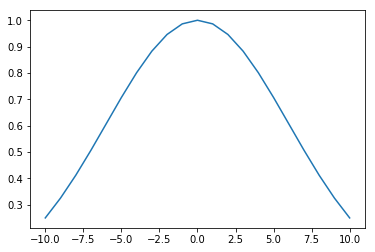

In [112]:
kernel_height = 10
sigma_height = 6
t2 = np.arange(-kernel_height, kernel_height+1)
plt.plot(t2, get_gaussian(kernel_height,sigma_height))

### Spatial Filter Kernel


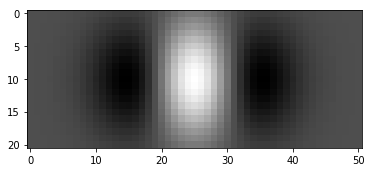

In [113]:
spatial_filter = get_convolution_kernel(kernel_width, kernel_height, sigma_width, sigma_height)
cv2.normalize(spatial_filter,spatial_filter)

plt.imshow(spatial_filter, cmap='gray')

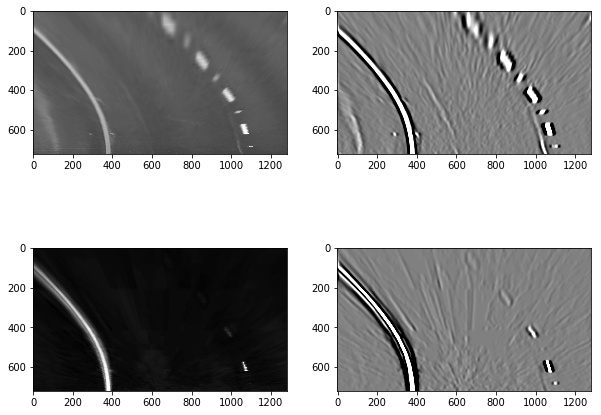

In [114]:
def filter_image(image, kernel):
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]

    return cv2.filter2D(l_channel, 1, kernel), cv2.filter2D(s_channel, 1, kernel) 

image_idx = 2
distorted_image = distorted_images[image_idx]
image_to_filter = undistorted_top_views[image_idx]
filtered_l_channel, filtered_s_channel = filter_image(image_to_filter,spatial_filter)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(plt_img_width, plt_img_height))
axs[0,0].imshow(cv2.cvtColor(image_to_filter, cv2.COLOR_RGB2HLS)[:,:,1], cmap='gray')
axs[0,1].imshow(filtered_l_channel, cmap='gray')
axs[1,0].imshow(cv2.cvtColor(image_to_filter, cv2.COLOR_RGB2HLS)[:,:,2], cmap='gray')
axs[1,1].imshow(filtered_s_channel, cmap='gray')


### Thresholded images


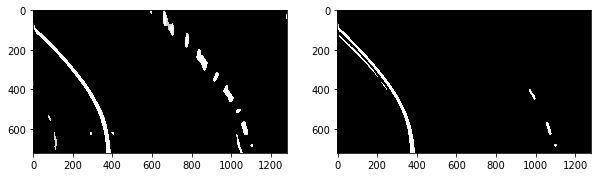

In [115]:
def threshold(image):
    normalized = cv2.normalize(
        image, 0,255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    _, normalized = cv2.threshold(normalized,200.0,255.0,cv2.THRESH_TOZERO)
    return normalized

normalized_filtered_l_channel = threshold(filtered_l_channel)
normalized_filtered_s_channel = threshold(filtered_s_channel)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(plt_img_width, plt_img_height))
axs[0].imshow(normalized_filtered_l_channel, cmap='gray')
axs[1].imshow(normalized_filtered_s_channel, cmap='gray')


### Merged Image

The lanes stand out now clearly. Both images will be merged in next step by taking the maximum values of each image.

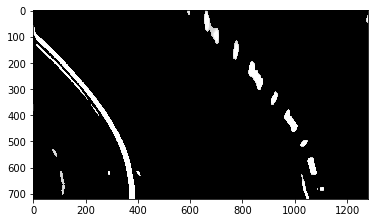

In [116]:
processed_image = np.maximum(normalized_filtered_l_channel, normalized_filtered_s_channel)
plt.imshow(processed_image, cmap='gray')

### Find Candidates for Lanes

The bottom part of the filtered and thresholded image is used as starting point to find lanes. A summation of the columns and smoothing of that part will show prominent peaks. This is where we start to extract lanes. 

In [117]:
def bottom_smoothed_histogram(image):
    height = image.shape[0]
    bottom = image[height - height//3:, :]
    histogram = np.sum(bottom, axis=0)
    
    window_width = 150
    window = np.ones(window_width)
    conv_signal = np.convolve(window, histogram)
    
    return conv_signal

# Create histogram of image binary activations
lane_histogram = bottom_smoothed_histogram(processed_image)

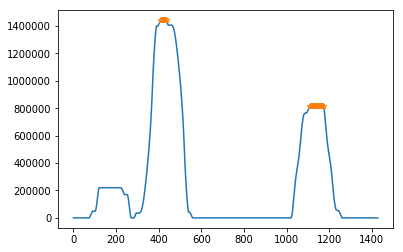

In [118]:
from skimage.feature import peak_local_max

# find the peaks in the histogram
histogram_peak_idx = peak_local_max(lane_histogram, min_distance=50, threshold_abs=400000)
histogram_peak_values =  lane_histogram[histogram_peak_idx]

# Visualize the resulting histogram and show the peaks
fig, ax = plt.subplots()
ax.plot(lane_histogram)
ax.plot(histogram_peak_idx,histogram_peak_values, '*')



### Find lanes

Sliding windows are drawn around the candidates and moved up along a probable path to the top of the images.

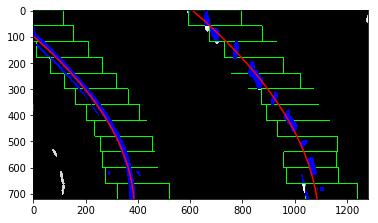

In [119]:
# get the middle point of plateaus 
def filter_local_maxima(local_maxima, gap):
    group = []
    filtered_local_maxima = []
    last_index = 0
    
    for maximum_index in local_maxima:
        if abs(maximum_index - last_index) > gap:
            group_size = len(group) 
            if group_size == 1:
                filtered_local_maxima.append(int(group[0]))
            
            if group_size > 1:
                filtered_local_maxima.append(int(group[0] + (group[group_size-1] - group[0]) / 2))
                
            group.clear()
        
        group.append(maximum_index)
        last_index = maximum_index

    group_size = len(group)
    
    if group_size == 1:
        filtered_local_maxima.append(int(group[0]))
    
    if group_size > 1:
        filtered_local_maxima.append(int(group[0] + (group[group_size-1] - group[0]) / 2))
                
    return filtered_local_maxima

    
def find_lane_pixels(image, n_search_windows, search_window_margin, minpix):
    out_img = np.dstack((image, image, image))
    
    lane_histogram = bottom_smoothed_histogram(processed_image)
    
    # find the peaks in the histogram
    histogram_peak_idxs = peak_local_max(lane_histogram, min_distance=50, threshold_abs=400000)
    
    # filter plateaus
    lane_positions = filter_local_maxima(histogram_peak_idxs, 10)
    
    #histogram_peak_values =  lane_histogram[histogram_peak_idxs]
    
    # Visualize the resulting histogram and show the peaks
    # fig, ax = plt.subplots()
    # ax.plot(lane_histogram)
    # ax.plot(histogram_peak_idxs,histogram_peak_values, '*')

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(image.shape[0]//n_search_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    good_lanes_inds = []
    
    image_height = image.shape[0]
    
    for lane_position_idx in range(len(lane_positions)):
        lane_inds = []
        current_lane_pos = lane_positions[lane_position_idx]
        
        for window in range(n_search_windows):
            win_y_low = image_height - (window + 1) * window_height
            win_y_high = image_height - window * window_height

            win_x_low = current_lane_pos - search_window_margin
            win_x_high = current_lane_pos + search_window_margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low),
                (win_x_high,win_y_high),(0,255,0), 2)
            
            # Identify the nonzero pixels in x and y within the window #
            good_lane_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            
            lane_inds.append(good_lane_inds)
            
            ### If you found > minpix pixels, recenter next window ###
            if len(good_lane_inds) > minpix:
                current_lane_pos = np.int(np.mean(nonzerox[good_lane_inds]))
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)        
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
            
        good_lanes_inds.append(lane_inds)    

    X = []
    Y = []
    
    # Extract left and right line pixel positions
    for lane_position_idx in range(len(lane_positions)):
        X.append(nonzerox[good_lanes_inds[lane_position_idx]])
        Y.append(nonzeroy[good_lanes_inds[lane_position_idx]])
    
    return X, Y, out_img

def get_lane_points(fit_params, image_height, max_points):
    # Generate x and y values for plotting
    ploty = np.linspace(0, image_height-1, max_points)
    
    try:
        fitx = fit_params[0]*ploty**2 + fit_params[1]*ploty + fit_params[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        fitx = 1*ploty**2 + 1*ploty
    
    return fitx, ploty
    

def lane_fitting(X, Y, image, draw):
    image_height = image.shape[0]
    fit_params_all_lanes = []
    
    for i in range(len(X)):        
        fit_params = np.polyfit(Y[i], X[i], 2)
        fit_params_all_lanes.append(fit_params)
        
        if draw == True:
            fitx, ploty = get_lane_points(fit_params, image_height, image_height)
            
            ## Visualization ##
            # Colors in the left and right lane regions
            image[Y[i], X[i]] = [0, 0, 255]
    
            # Plots the left and right polynomials on the lane lines
            plt.plot(fitx, ploty, color='red')

    return fit_params_all_lanes        
        
lanes_x, lanes_y, sliding_window_image = find_lane_pixels(processed_image, 12, 100, 50)  
lane_fitting_params = lane_fitting(lanes_x, lanes_y, sliding_window_image, draw=True)
plt.imshow(sliding_window_image)


### Search lanes around polynom

Polynoms that where found in prior search will be used to find lanes in the next image.

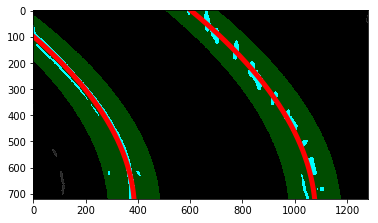

In [120]:
def search_lanes_around_polynoms(lanes_fitting_params, margin, image, draw):
    image_height = image.shape[0]
    
    # Grab activated pixels
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img = []
    window_img = []
    result_image = []
    
    if draw == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((image, image, image))*255
        window_img = np.zeros_like(out_img)
    
    for i in range(len(lanes_fitting_params)):
        lane_fitting_params = lanes_fitting_params[i]
        
        lane_inds = ((nonzerox > (lane_fitting_params[0]*(nonzeroy**2) + lane_fitting_params[1]*nonzeroy + 
                        lane_fitting_params[2] - margin)) & (nonzerox < (lane_fitting_params[0]*(nonzeroy**2) + 
                        lane_fitting_params[1]*nonzeroy + lane_fitting_params[2] + margin)))
    
        
        # Again, extract left and right line pixel positions
        lane_x = nonzerox[lane_inds]
        lane_y = nonzeroy[lane_inds] 
    
        # Fit new polynomials
        new_lane_fitting_params = lane_fitting([lane_x], [lane_y], image, draw=False)
        lanes_fitting_params[i] = new_lane_fitting_params[0]
        
        if draw == True:
            ## Visualization ##
            fitx, ploty = get_lane_points(new_lane_fitting_params[0], image_height, image_height)
        
        
            # Color on lane pixel
            out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 255, 255]
        
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            line_window1 = np.array([np.transpose(np.vstack([fitx-margin, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, 
                                      ploty])))])
            line_pts = np.hstack((line_window1, line_window2))
        
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
            result_image = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            
            # Plot the polynomial lines onto the image
            plt.plot(fitx, ploty, color='red',  linewidth=5)
            ## End visualization steps ##
    
    return lanes_fitting_params, result_image

# Run image through the pipeline
processed_image_poly_lane_fit = processed_image.copy()
lanes_fitting_params, result_image = search_lanes_around_polynoms(lane_fitting_params, 100, processed_image_poly_lane_fit, draw=True)

# View your output
plt.imshow(result_image)

### Getting Curvature from Polynoms

Curvature R is calculated for a second order polynomial 

$$f(y)=Ax^2+Bx+C$$

with this function:

$$R_{curve}=\frac{(1+(2Ay+B)^2)^{3/2}}{|2A|}$$



In [127]:
def meassure_curvature(polynomial, y, xm_per_pix, ym_per_pix, image_height):
    # generate new x and y values along the curve (use only a small subset of points)
    fitx, ploty = get_lane_points(polynomial, image_height, 30)
    fitx *= xm_per_pix
    ploty *= ym_per_pix
    
    # transform x and y coordinates to real world and fit a polynomial
    fit_params = np.polyfit(ploty, fitx, 2)
    
    A = fit_params[0]
    B = fit_params[1]
    R = 0
    
    y *= ym_per_pix
    
    if (A != 0.0):
        R = ((1 + (2 * A * y + B) ** 2) ** (3/2)) / np.abs(2 * A)
        
    return R, fitx[-1]

lane_points = []
xm_per_pix = 3.7/700
ym_per_pix = 30.0/720
Rs = []

for i in range(len(lanes_fitting_params)):
    image_height = processed_image.shape[0]
    R, lane_point = meassure_curvature(
        lane_fitting_params[i], y=(image_height - 1), xm_per_pix = xm_per_pix, ym_per_pix = ym_per_pix, image_height=image_height)
    lane_points.append(lane_point)
    Rs.append(R)
    print(R, "m")

214.0262521114315 m
190.61895556057746 m


### Vehicle Position

The vehicle position is calculated based on the bottom lane points and the center of the image. 

In [128]:
def get_vehicle_position(lane_points, image_width_in_m):
    pos_in_m = 0.0
    left = 0
    right = image_width_in_m
    middle = image_width_in_m / 2
    
    # get the closest points from center
    for lane_point in lane_points:
        if (lane_point > left and lane_point < middle):
            left = lane_point
        
        if (lane_point > middle and lane_point < right):
            right = lane_point
            
    pos_in_m = ((left + right) / 2 - middle)
    return pos_in_m

image_width = processed_image.shape[1]
car_position = get_vehicle_position(lane_points, image_width * xm_per_pix)
print('Car Position:', car_position, 'm')
    

Car Position: 0.478631596874711 m


### Show current lane in the original image

In [ ]:
def draw_current_lane_on_image(processed_image, original_image, lanes_fitting_params, Minv, 
                               Rs, position):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(processed_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_params = lanes_fitting_params[0]
    right_params = lanes_fitting_params[-1]
    
    image_height = processed_image.shape[0]
    bottom_y = image_height - 1 
    lane_points = []
    middle = processed_image.shape[1] / 2
    
    left = 0
    right = processed_image.shape[1] - 1
    
    R_left = 0
    R_right = 0
    
    # get the closest points from center
    for fit_params in lanes_fitting_params:
        try:
            fitx = fit_params[0]*bottom_y**2 + fit_params[1]*bottom_y + fit_params[2]
            lane_points.append(fitx)
            
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            fitx = 1*bottom_y**2 + 1*bottom_y
            lane_points.append(fitx)     
        
    for i in range(len(lane_points)):
        lane_point = lane_points[i]
        if (lane_point > left and lane_point < middle):
            left = lane_point
            left_params = lanes_fitting_params[i]
            R_left = Rs[i]
        
        if (lane_point >= middle and lane_point < right):
            right = lane_point
            right_params = lanes_fitting_params[i]
            R_right = Rs[i]

    left_fitx, ploty = get_lane_points(left_params, image_height, image_height)
    right_fitx, ploty = get_lane_points(right_params, image_height, image_height)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
       # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_width, image_height)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(R_left),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(R_right),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(position), 'left' if position < 0 else 'right'),(50,110), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)
    return result
    
plt.figure(figsize=(plt_img_width,plt_img_height))    
plt.imshow(draw_current_lane_on_image(
    processed_image, distorted_image, lane_fitting_params, Minv=Minv, Rs=Rs, position=car_position))


TypeError: draw_current_lane_on_image() got an unexpected keyword argument 'car_position'